In [222]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time


In [223]:
rootfolder = '../'

Useful function for plot a 2D dictionary

In [224]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [225]:
def OMP(s, D, L, tau):
  M, N = D.shape
  x = np.zeros(N)
  r = s.copy().flatten()
  omega = []
  while np.linalg.norm(r) > tau and len(omega) < L:
    eps = np.zeros(N)
    for j in range(N):
      d_j = D[:, j]
      d = np.dot(r.T, d_j)**2/np.linalg.norm(d_j)
      eps[j] = d
    jStar = np.argmax(eps)
    omega.append(jStar)
    D_omega = D[:, omega]
    coeffs_omega = np.linalg.lstsq(D_omega, s.flatten(), rcond=None)[0]
    x[omega] = coeffs_omega
    r = s.flatten() - D_omega @ coeffs_omega
  return x

Load the image and rescale it in $[0,1]$

In [226]:
img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [227]:
sigma_noise = 20/255
noisy_img = img + np.random.random(size=imsz) * sigma_noise

Compute the PSNR of the noisy input

In [228]:
def psnr(img1, img2, max_pixel=1.0):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10(max_pixel ** 2 / mse)

In [229]:
psnr_noisy = psnr(img, noisy_img)

Text(0.5, 1.0, 'Noisy image, PSNR = 26.89')

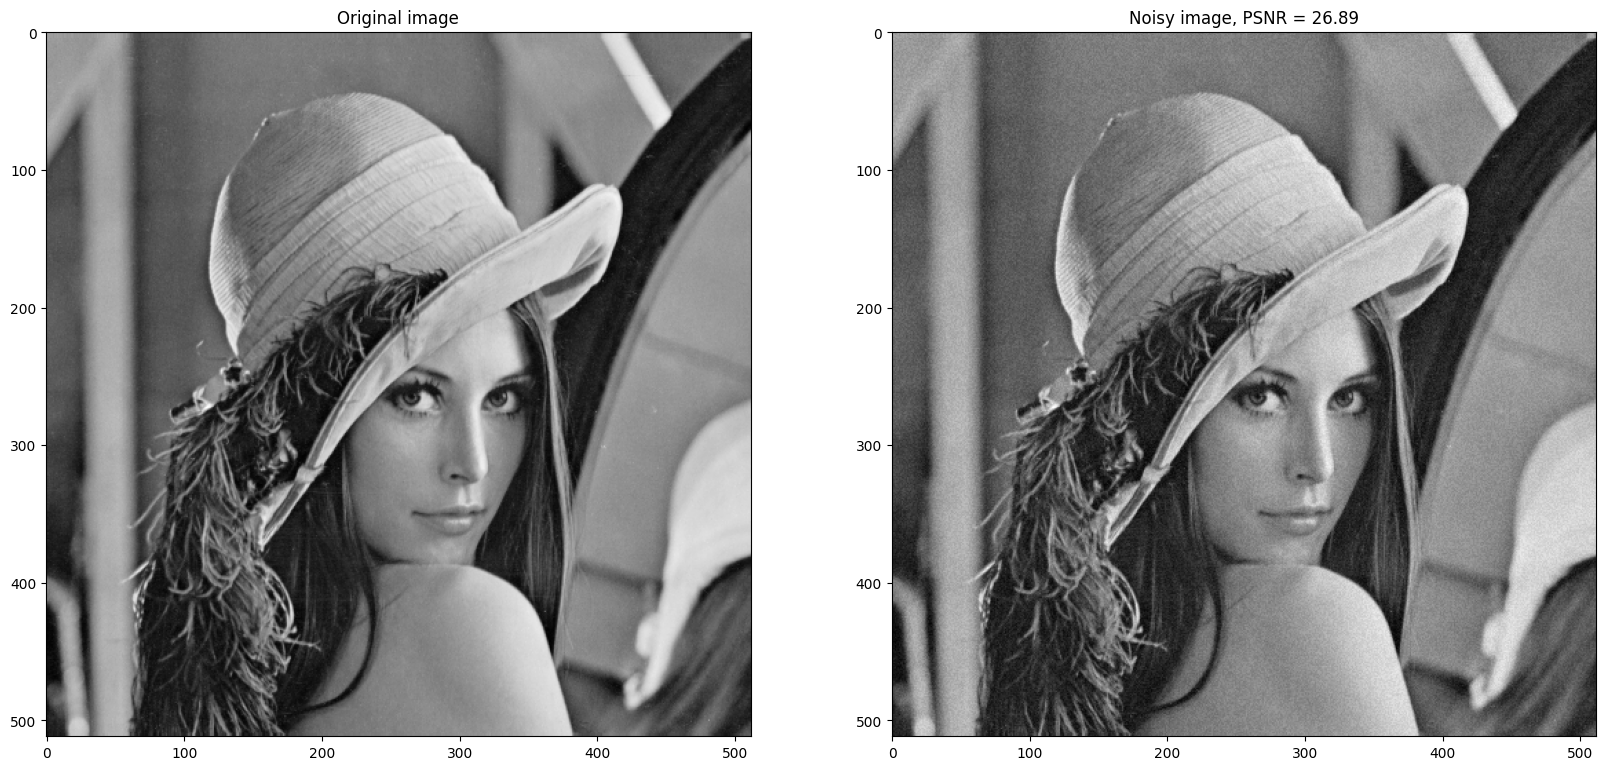

In [230]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Load and display the dictionary learned from patches

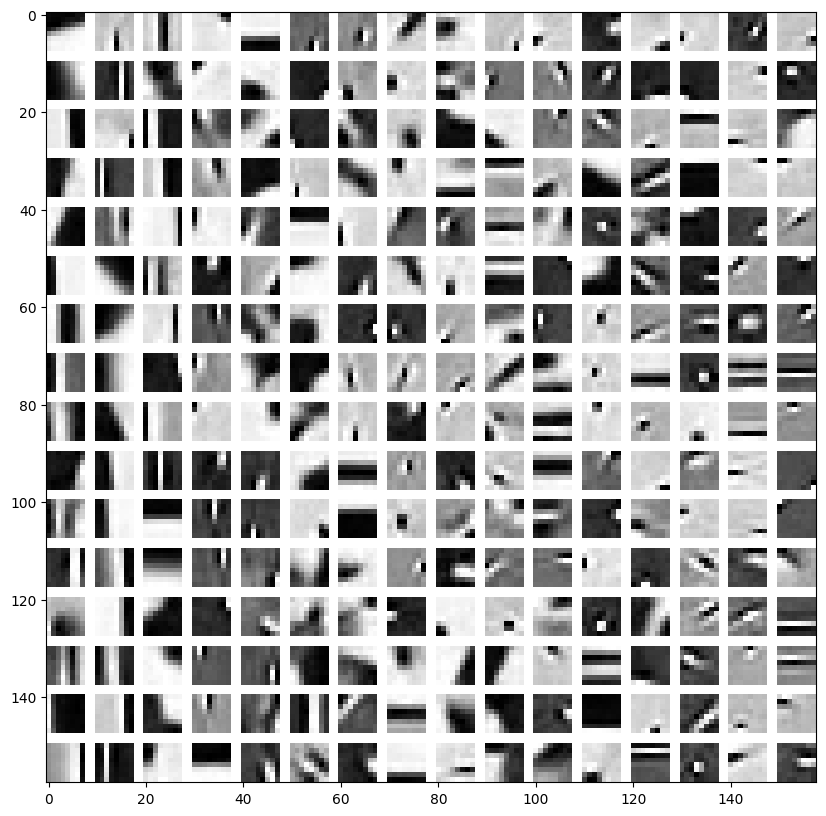

In [231]:
D = loadmat(f'{rootfolder}/data/dict_nat_img.mat')['D']

# display the learned basis
D_img = get_dictionary_img(D)
plt.figure(figsize=(10,10))
plt.imshow(D_img, cmap='gray')

Denoising
---------


In [232]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# set the threshold
tau = 1.15 * p * sigma_noise

# define the step (=p for non overlapping paches)
# STEP = 4 
STEP = 1 # might be very time consuming, start with larger STEP

Operate patchwise

In [233]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = img[i : i + p, j : j + p]

        # store and subtract the mean
        s_mean = np.mean(s)
        s_tilde = s - s_mean

        # perform the sparse coding
        x = OMP(s_tilde, D, 1, tau)

        # perform the reconstruction
        s_hat = np.dot(D, x)

        # add back the mean
        s_hat = s_hat + s_mean

        # put the denoised patch into the estimated image using uniform weights
        img_hat[i : i + p, j : j + p] += s_hat.reshape((p, p))

        # store the weight of the current patch in the weight matrix
        weights[i : i + p, j : j + p] += 1

Normalize the estimated image with the computed weights

In [234]:
img_hat = img_hat / weights

Compute the PSNR of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 30.41')

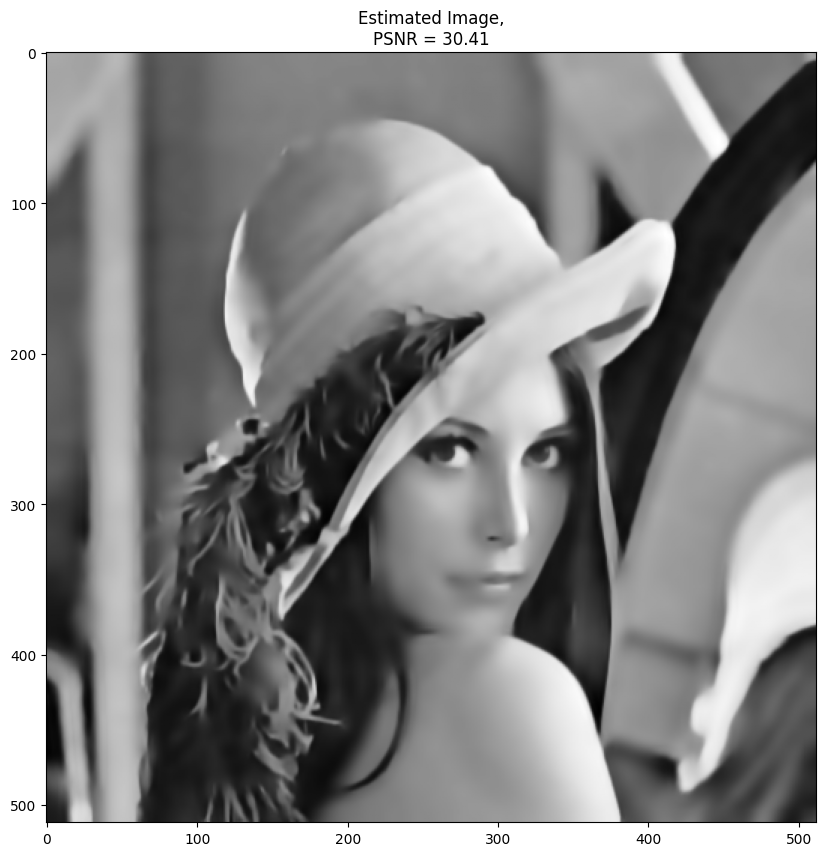

In [235]:
psnr_hat = psnr(img, img_hat)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
